In [52]:
import pandas as pd
import numpy as np
import ast
import pickle

In [112]:
with open("../sorted_360_brand_list.pkl", 'rb') as f:
    all_brands = pickle.load(f)
with open("../sorted_3748_inf_list.pkl", 'rb') as f:
    all_infs = pickle.load(f)

In [113]:
with open("../train_test_split/train_brand_node_id.pkl", 'rb') as f:
    train_brand_node_id = pickle.load(f)
with open("../train_test_split/train_inf_node_id.pkl", 'rb') as f:
    train_inf_node_id = pickle.load(f)
with open("../train_test_split/test_brand_node_id.pkl", 'rb') as f:
    test_brand_node_id = pickle.load(f)
with open("../train_test_split/test_inf_node_id.pkl", 'rb') as f:
    test_inf_node_id = pickle.load(f)

In [55]:
with open('train_concept_profile_id_dict_new.pkl', 'rb') as f:
    train_concept_id_dict = pickle.load(f)
train_id_concept_dict = {v: k for k,v in train_concept_id_dict.items()}

# Visualize function

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [25]:
def tsne_visualize_concept(node_embeddings, text_label, category_label, no_visual_index, alpha=0.7, custom_s=50, font_size=None, big=False):

    # apply t-SNE to reduce the dimensionality of the embeddings to 2 dimensions
    node_embeddings_2d = TSNE(n_components=2).fit_transform(node_embeddings)
    print(node_embeddings_2d.shape)

    fig, ax = plt.subplots(figsize=(30, 30))
    label_offset = 0.1
    cmap = plt.cm.get_cmap('tab20', len(np.unique(category_label)))
    

#     for j, (x, y) in enumerate(node_embeddings_2d):
#         x_jitter = x + 0.1*np.random.rand(1) - 0.05
#         y_jitter = y + 0.1*np.random.rand(1) - 0.05
#         ax.scatter(x_jitter, y_jitter, color='tab:blue')
#         ax.text(x_jitter - 0.05, y_jitter, text_label[j], fontsize=8, color='black', ha='right', va='center')
    jitter_emb = []
    for i in range(node_embeddings_2d.shape[0]):
        if i in no_visual_index:
            continue
        x = node_embeddings_2d[i][0] + 0.1*np.random.rand(1) - 0.05
        y = node_embeddings_2d[i][1] + 0.1*np.random.rand(1) - 0.05
        jitter_emb.append([x, y])
    jitter_emb = np.array(jitter_emb)
    jitter_emb = jitter_emb.reshape(len(text_label), 2)
    print(jitter_emb.shape)

    groups = pd.DataFrame(jitter_emb, columns=['x', 'y']).assign(category=category_label, text=text_label).groupby('category')
    for i, (name, points) in enumerate(groups):
        if i < 10:
            ax.scatter(points.x, points.y, label=name, alpha=alpha, s=custom_s)
        elif i == 10:
            ax.scatter(points.x, points.y, label=name, color='gold', alpha=alpha, s=custom_s)
        elif i == 11:
            ax.scatter(points.x, points.y, label=name, color='darkviolet', alpha=alpha, s=custom_s)
        else:
            ax.scatter(points.x, points.y, label=name, color='tan', alpha=alpha)
#         ax.text(points.x - 0.05, points.y, points.text, fontsize=8, color='black', ha='right', va='center')
        for j, txt in enumerate(points['text']):
            x = points['x'].iloc[j]
            y = points['y'].iloc[j]
            ax.annotate(txt, (x, y), xytext=(x-0.04, y), ha='right', va='center', fontsize=font_size)
    
    if big:
        ax.legend(bbox_to_anchor = (1.1, 0.6), loc='center right', handlelength=5, borderpad=1.2, labelspacing=1.2)
    else:
        ax.legend(bbox_to_anchor = (1.1, 0.6), loc='center right')
    plt.show()
#     if save:
#         plt.savefig('pretrained_graph/models/'+model_name+'.png')
    return jitter_emb

In [ ]:
def visualize_concept(jitter_emb, text_label, category_label, no_visual_index, alpha=0.7, custom_s=80, font_size=None, big=False, fig_size=(45,15)):

    fig, ax = plt.subplots(figsize=fig_size)
    label_offset = 0.1
    cmap = plt.cm.get_cmap('tab20', len(np.unique(category_label)))
    
    groups = pd.DataFrame(jitter_emb, columns=['x', 'y']).assign(category=category_label, text=text_label).groupby('category')
    for i, (name, points) in enumerate(groups):
        if i < 10:
            ax.scatter(points.x, points.y, label=name, alpha=alpha, s=custom_s)
        elif i == 10:
            ax.scatter(points.x, points.y, label=name, color='gold', alpha=alpha, s=custom_s)
        elif i == 11:
            ax.scatter(points.x, points.y, label=name, color='darkviolet', alpha=alpha, s=custom_s)
        else:
            ax.scatter(points.x, points.y, label=name, color='tan', alpha=alpha)
#         ax.text(points.x - 0.05, points.y, points.text, fontsize=8, color='black', ha='right', va='center')
        for j, txt in enumerate(points['text']):
            x = points['x'].iloc[j]
            y = points['y'].iloc[j]
            ax.annotate(txt, (x, y), xytext=(x-0.06, y), ha='right', va='center', fontsize=font_size)
    
    if big:
        ax.legend(bbox_to_anchor = (1.1, 0.6), loc='center right', handlelength=5, borderpad=1.2, labelspacing=1.2)
        ax.legend(bbox_to_anchor = (1.1, 0.6), loc='center right', prop={'size': 20})
    else:
        ax.legend(bbox_to_anchor = (1.1, 0.6), loc='center right')
    plt.show()
#     if save:
#         plt.savefig('pretrained_graph/models/'+model_name+'.png')
    return

# 用我的提及關係、hashtag 關係來算分數訓練 node2vec

In [109]:
with open('train_concept_profile_id_dict_new.pkl', 'rb') as f:
    my_concept_dict = pickle.load(f)

In [326]:
with open('../train_test_split/train_brand_mention_brand.pickle', 'rb') as f:
    train_bmb = pickle.load(f)
with open('../train_test_split/train_brand_mention_inf.pickle', 'rb') as f:
    train_bmi = pickle.load(f)
with open('../train_test_split/train_inf_mention_brand.pickle', 'rb') as f:
    train_imb = pickle.load(f)
with open('../train_test_split/train_inf_mention_inf.pickle', 'rb') as f:
    train_imi = pickle.load(f)

In [303]:
with open('brand_concept_profile_noconc_id_pair_new.pkl', 'rb') as f:
    new_brand_concept_id_pair = pickle.load(f)
with open('inf_concept_profile_noconc_id_pair_new.pkl', 'rb') as f:
    new_inf_concept_id_pair = pickle.load(f)

In [304]:
brand_has_mycon = dict()
for pair in new_brand_concept_id_pair:
    brand_id = pair[0]
    con_id = pair[1]
    if brand_id not in brand_has_mycon:
        brand_has_mycon[brand_id] = set()
    brand_has_mycon[brand_id].add(con_id)

In [305]:
inf_has_mycon = dict()
for pair in new_inf_concept_id_pair:
    inf_id = pair[0]
    con_id = pair[1]
    if inf_id not in inf_has_mycon:
        inf_has_mycon[inf_id] = set()
    inf_has_mycon[inf_id].add(con_id)

In [258]:
with open('train_concept_profile_id_dict_new.pkl', 'rb') as f:
    my_concept_dict = pickle.load(f)

In [273]:
my_concept_list = ['']*len(my_concept_dict)

In [274]:
for key in my_concept_dict:
    my_concept_list[my_concept_dict[key]] = key

In [275]:
len(my_concept_list)

412

In [276]:
rev_my_concept_dict = {v:k for k,v in my_concept_dict.items()}

## 提及關係

In [338]:
con_coocf_my = dict()

In [339]:
coocf_filename = 'con_coocf.pkl'

In [340]:
# 加入 bb 提及關係
for pair in train_bmb:
    brand_id = pair[0]
    m_brand_id = pair[1]
    
    if brand_id in train_brand_ids and m_brand_id in train_brand_ids:
    
        for i in range(len(my_concept_list)):
            for j in range(i+1, len(my_concept_list)):
                if i==j:
                    continue

                if (i, j) in con_coocf_my:
                    score = con_coocf_my[(i, j)]
                else:
                    score = 0
                
                # 同帳號關係
#                 if i in brand_has_mycon[brand_id] and j in brand_has_mycon[brand_id]:
#                     score += 1
#                     print((i, j), 1)
#                 if i in brand_has_mycon[m_brand_id] and j in brand_has_mycon[m_brand_id]:
#                     score += 1
#                     print((i, j), 2)
                if i in brand_has_mycon[brand_id] and j in brand_has_mycon[m_brand_id]:
                    score += 1
#                     print((i, j), 3)
#                     print(my_concept_list[i], my_concept_list[j])
                if j in brand_has_mycon[brand_id] and i in brand_has_mycon[m_brand_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])
#                     print((i, j), 4)

                con_coocf_my[(i, j)] = score
    else:
        print(pair, 'not in train split.')
print(len(con_coocf_my))
with open(coocf_filename, 'wb') as f:
    pickle.dump(con_coocf_my, f)

# 加入 bi 提及關係
for pair in train_bmi:
    brand_id = pair[0]
    inf_id = pair[1]
    
    if brand_id in train_brand_ids and inf_id in train_inf_ids:
    
        for i in range(len(my_concept_list)):
            for j in range(i+1, len(my_concept_list)):
                if i==j:
                    continue

                if (i, j) in con_coocf_my:
                    score = con_coocf_my[(i, j)]
                else:
                    score = 0

#                 if i in brand_has_mycon[brand_id] and j in brand_has_mycon[brand_id]:
#                     score += 1
#                     print((i, j), 1)
#                 if i in brand_has_mycon[m_brand_id] and j in brand_has_mycon[m_brand_id]:
#                     score += 1
#                     print((i, j), 2)
                if i in brand_has_mycon[brand_id] and j in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])
                if j in brand_has_mycon[brand_id] and i in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])

                con_coocf_my[(i, j)] = score
    else:
        print(pair, 'not in train split.')
print(len(con_coocf_my))
with open(coocf_filename, 'wb') as f:
    pickle.dump(con_coocf_my, f)

# 加入 ii 提及關係
for pair in train_imi:
    inf_id = pair[0]
    m_inf_id = pair[1]
    
    if inf_id in train_inf_ids and m_inf_id in train_inf_ids:
    
        for i in range(len(my_concept_list)):
            for j in range(i+1, len(my_concept_list)):
                if i==j:
                    continue

                if (i, j) in con_coocf_my:
                    score = con_coocf_my[(i, j)]
                else:
                    score = 0

#                 if i in brand_has_mycon[brand_id] and j in brand_has_mycon[brand_id]:
#                     score += 1
#                     print((i, j), 1)
#                 if i in brand_has_mycon[m_brand_id] and j in brand_has_mycon[m_brand_id]:
#                     score += 1
#                     print((i, j), 2)
                if i in inf_has_mycon[m_inf_id] and j in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])
                if j in inf_has_mycon[m_inf_id] and i in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])

                con_coocf_my[(i, j)] = score
    else:
        break
        print(pair, 'not in train split.')
print(len(con_coocf_my))
with open(coocf_filename, 'wb') as f:
    pickle.dump(con_coocf_my, f)

# 加入 ib 提及關係
for pair in train_imb:
    inf_id = pair[0]
    brand_id = pair[1]
    
    if inf_id in train_inf_ids and brand_id in train_brand_ids:
    
        for i in range(len(my_concept_list)):
            for j in range(i+1, len(my_concept_list)):
                if i==j:
                    continue

                if (i, j) in con_coocf_my:
                    score = con_coocf_my[(i, j)]
                else:
                    score = 0

#                 if i in brand_has_mycon[brand_id] and j in brand_has_mycon[brand_id]:
#                     score += 1
#                     print((i, j), 1)
#                 if i in brand_has_mycon[m_brand_id] and j in brand_has_mycon[m_brand_id]:
#                     score += 1
#                     print((i, j), 2)
                if i in brand_has_mycon[brand_id] and j in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])
                if j in brand_has_mycon[brand_id] and i in inf_has_mycon[inf_id]:
                    score += 1
#                     print(my_concept_list[i], my_concept_list[j])

                con_coocf_my[(i, j)] = score
    else:
        print(pair, 'not in train split.')
        break
print(len(con_coocf_my))
with open(coocf_filename, 'wb') as f:
    pickle.dump(con_coocf_my, f)

84666
84666
84666
84666


## hashtag 關係

In [449]:
with open(coocf_filename, 'rb') as f:
    con_coocf_my = pickle.load(f)

In [344]:
with open('sorted_concept_name_pair_scorer_0615_r1.pkl', 'rb') as f:
    sorted_concept_name_pair_score = pickle.load(f)
with open('train_concept_profile_id_dict_new.pkl', 'rb') as f:
    train_concept_id_dict = pickle.load(f)

In [345]:
len(train_concept_id_dict)

412

In [346]:
sorted_concept_id_pair_score = dict()
for pair in sorted_concept_name_pair_score:
    id0 = train_concept_id_dict[pair[0]]
    id1 = train_concept_id_dict[pair[1]]
    if id0 < id1:
        sorted_concept_id_pair_score[(id0, id1)] = sorted_concept_name_pair_score[pair]
    else:
        sorted_concept_id_pair_score[(id1, id0)] = sorted_concept_name_pair_score[pair]

In [348]:
for pair, score in sorted_concept_id_pair_score.items():
    if score < 8:
        continue
        
    if pair not in con_coocf_my:
        con_coocf_my[pair] = score
    else:
        con_coocf_my[pair] += score

In [349]:
all_notzero_id = set()
for key in con_coocf_my:
    if con_coocf_my[key] != 0:
        all_notzero_id.add(key[0])
        all_notzero_id.add(key[1])

In [350]:
len(all_notzero_id)

381

In [352]:
iso_cons = set(range(412)) - all_notzero_id
len(iso_cons)

31

In [353]:
train_id_concept_dict = {v: k for k,v in train_concept_id_dict.items()}

## 將 coocf 分數儲存成 node2vec input

In [355]:
import math
with open('con_coocf.txt', 'w') as file:
    for key in con_coocf_my:
        if con_coocf_my[key] == 0:
            continue
        line = str(key[0])+ ' ' + str(key[1]) + ' ' + str(float(math.sqrt(con_coocf_my[key]/2)))
        file.write(line + '\n')

## 跑 node2vec

必須跑 attribute co-occurrence graph network/src 裡面的 main.py，我之前都在本機跑，所以路徑要改

In [ ]:
!python main.py --input con_coocf.txt --graph-format edgelist --output node2vec_embedding_0615_r1_sqrt.txt --weighted --number-walks 50


## 視覺化

In [450]:
my_emb = dict()
with open('node2vec_embedding_0615_r1_sqrt.txt', 'r') as file:
    for i, line in enumerate(file):
        if i == 0:
            continue
        values = line.split()
        my_emb[values[0]] = np.array(values[1:])
        

print(len(my_emb))

327


In [ ]:
iso_cons = set(range(412)) - set([int(i) for i in my_emb.keys()])
iso_cons

In [360]:
# 為了更清楚，只留下一些代表性的 concept。
with open('remain_concept_cat.pkl', 'rb') as f:
    remain_concept_cat = pickle.load(f)

In [361]:
print(remain_concept_cat)

{'cake': 'food', 'baking': 'food', 'food': 'food', 'chef': 'food', 'restaurant': 'food', 'recipe': 'food', 'drink': 'drink', 'brewer': 'drink', 'beer': 'drink', 'whiskey': 'drink', 'cocktail': 'drink', 'vodka': 'drink', 'makeup': 'makeup', 'lipstick': 'makeup', 'cosmetics': 'makeup', 'eyeliner': 'makeup', 'beauty': 'makeup', 'skincare': 'makeup', 'clothes': 'clothing', 'shirt': 'clothing', 'outfit': 'clothing', 'pants': 'clothing', 'airline': 'airline', 'pilot': 'airline', 'aviation': 'airline', 'airplane': 'airline', 'auto': 'auto', 'car': 'auto', 'driver': 'auto', 'truck': 'auto', 'motorbike': 'auto', 'automotive-manufacturing': 'auto'}


In [453]:
no_cat = []
for i in range(412):
    if train_id_concept_dict[i] not in remain_concept_cat:
        no_cat.append(i)

In [455]:
my_node_emb = []
no_visual_index = []
for i in range(412):
    if i not in iso_cons:
        my_node_emb.append(my_emb[str(i)].astype(float))
        if i in no_cat:
            no_visual_index.append(len(my_node_emb)-1)
    else: # 要視覺化的點沒 embedding
        if train_id_concept_dict[i] in remain_concept_cat:
            my_node_emb.append(np.zeros(128))
        
my_node_emb = np.array(my_node_emb)
my_node_emb.shape

(329, 128)

In [456]:
con_list = []
for i in range(412):
    if i not in iso_cons and i not in no_cat:
        con_list.append(train_id_concept_dict[i])
    if i in iso_cons and train_id_concept_dict[i] in remain_concept_cat:
        con_list.append(train_id_concept_dict[i])
len(con_list)

32

In [457]:
cat_list = []
for i in range(412):
#     if i not in iso_cons:
    if train_id_concept_dict[i] not in remain_concept_cat:
        continue
    else:
        cat_list.append(remain_concept_cat[train_id_concept_dict[i]])
len(cat_list)

32

/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(381, 2)
(32, 2)


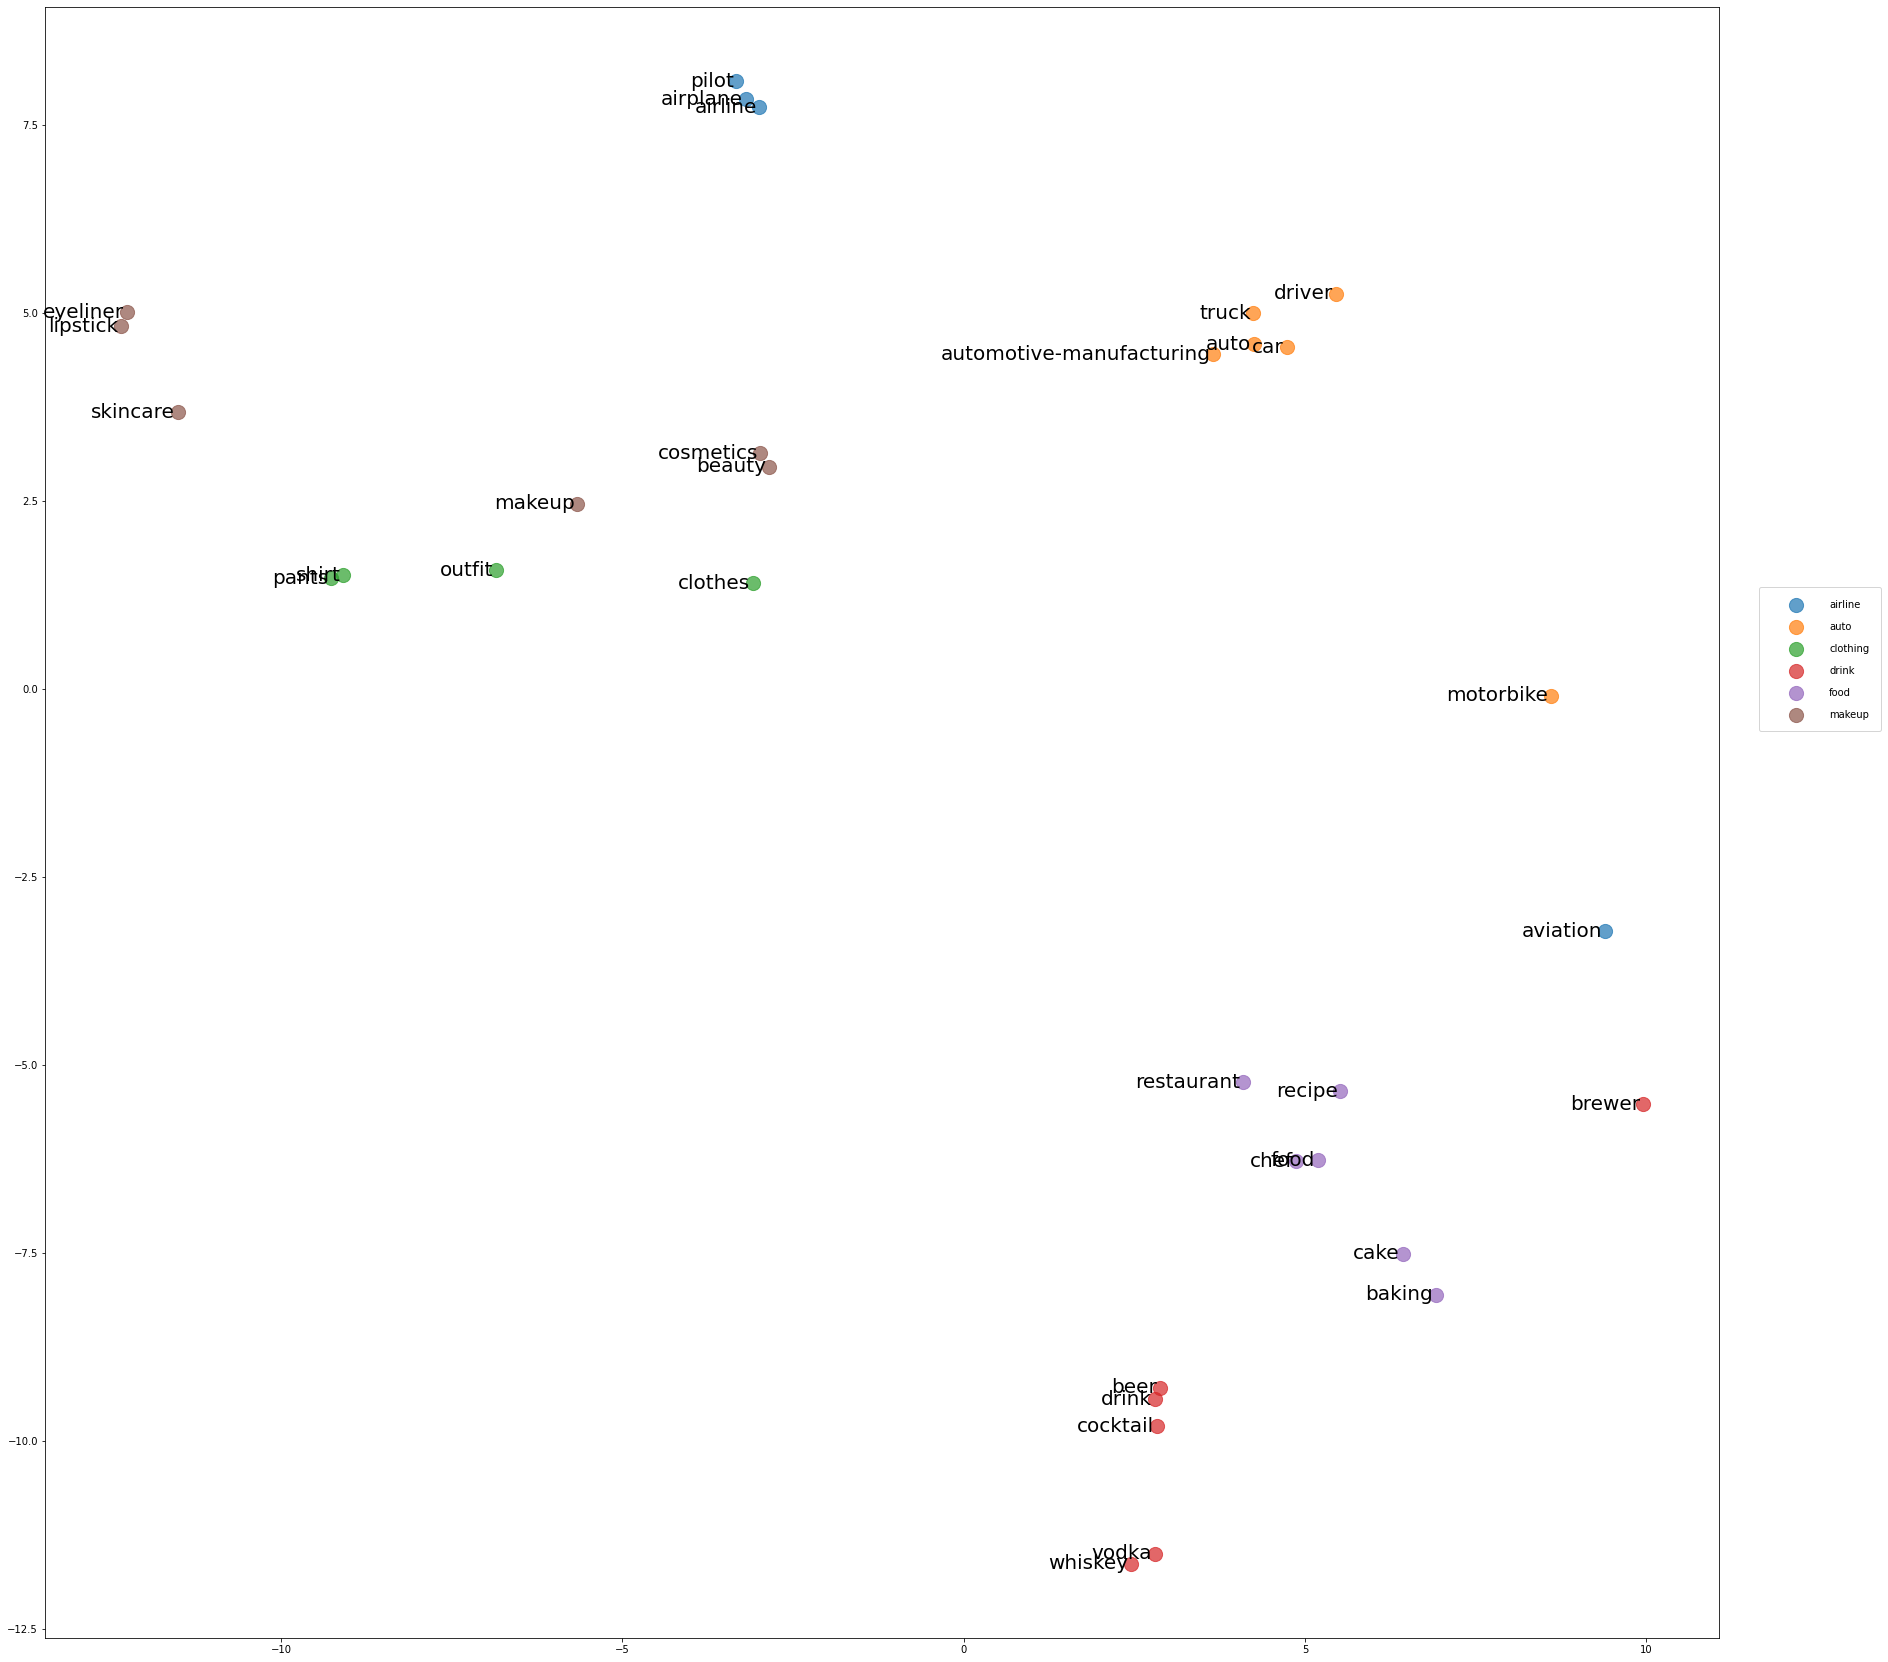

In [367]:
tts = tsne_visualize_concept(my_node_emb, con_list, cat_list, no_visual_index, custom_s=200, font_size=20, big=True)


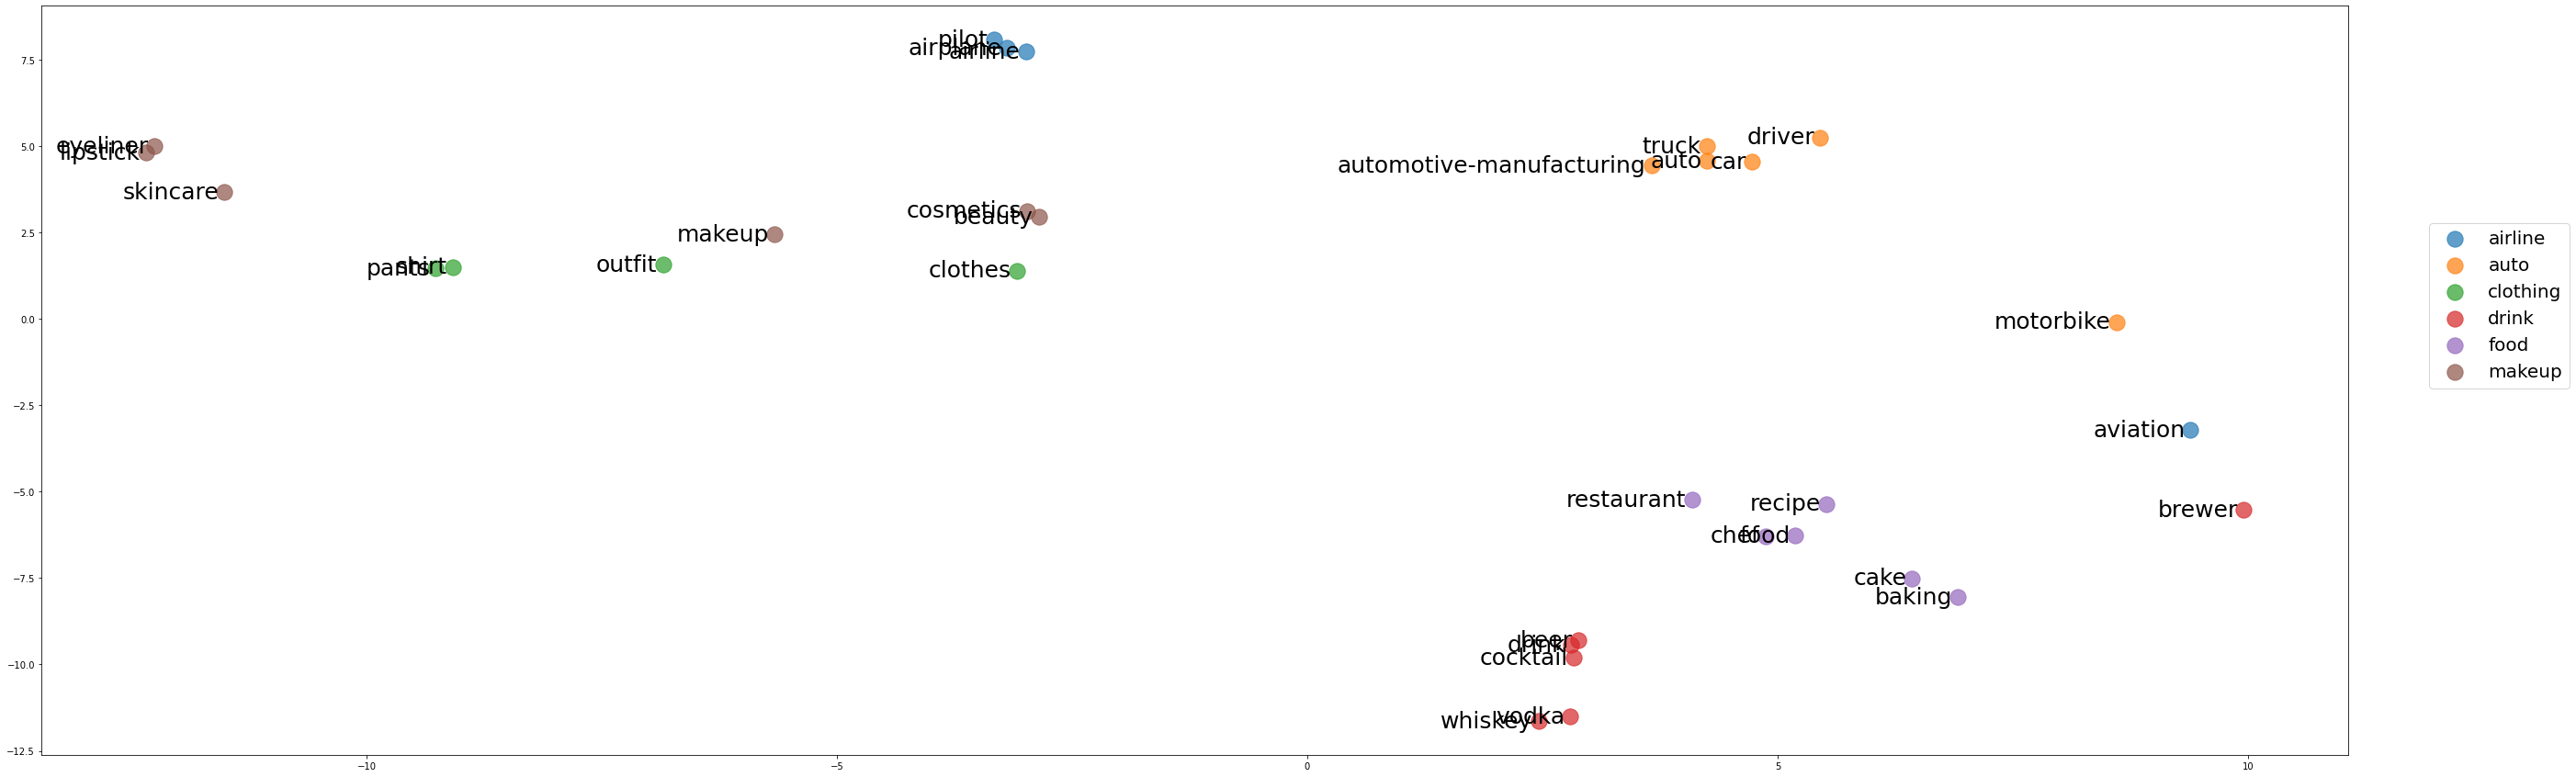

In [369]:
visualize_concept(tts, con_list, cat_list, no_visual_index, custom_s=300, font_size=25, big=True, fig_size=(45,15))


# Inference with weighted version

In [468]:
with open('brand_isa_concept_profile_hashtag_id_pair_weighted_0615_r1.pkl', 'rb') as f:
    brand_concept_id_pair_weighted = pickle.load(f)
with open('inf_isa_concept_profile_hashtag_id_pair_weighted_0615_r1.pkl', 'rb') as f:
    inf_concept_id_pair_weighted = pickle.load(f)

In [ ]:
len(brand_concept_id_pair_weighted), len(inf_concept_id_pair_weighted)

In [470]:
each_brand_weight_sum = [0] * 360
each_inf_weight_sum = [0] * 3748
for pair, weight in brand_concept_id_pair_weighted.items():
    aid = pair[0]
    each_brand_weight_sum[aid] += weight
    
for pair, weight in inf_concept_id_pair_weighted.items():
    aid = pair[0]
    each_inf_weight_sum[aid] += weight

In [ ]:
for i in range(360):
    if each_brand_weight_sum[i] == 0:
        each_brand_weight_sum[i] = 1

In [ ]:
for i in range(3748):
    if each_inf_weight_sum[i] == 0:
        each_inf_weight_sum[i] = 1

In [473]:
brand_node_emb = [0] * 360
for pair, weight in brand_concept_id_pair_weighted.items():
    brand_id = pair[0]
    con_id = pair[1]
    if str(con_id) not in my_emb:
        continue
    if type(brand_node_emb[brand_id]) == int:   # first
        brand_node_emb[brand_id] = (my_emb[str(con_id)].astype(float)) * weight
    else:
        current_w_emb = (my_emb[str(con_id)].astype(float)) * weight
        brand_node_emb[brand_id] += current_w_emb

for i in range(360):
    brand_node_emb[i] = brand_node_emb[i] / each_brand_weight_sum[i]

In [474]:
for i in range(360):
    if type(brand_node_emb[i]) != np.ndarray:
        print(i)
        brand_node_emb[i] = np.zeros(128)

272


In [475]:
for i in range(360):
    if type(brand_node_emb[i]) != np.ndarray:
        print(i)

In [476]:
inf_node_emb = [0] * 3748
for pair, weight in inf_concept_id_pair_weighted.items():
    inf_id = pair[0]
    con_id = pair[1]
    if str(con_id) not in my_emb:
        continue
    if type(inf_node_emb[inf_id]) == int:   # first
        inf_node_emb[inf_id] = (my_emb[str(con_id)].astype(float)) * weight
    else:
        current_w_emb = (my_emb[str(con_id)].astype(float)) * weight
        inf_node_emb[inf_id] += current_w_emb

for i in range(3748):
    inf_node_emb[i] = inf_node_emb[i] / each_inf_weight_sum[i]

In [ ]:
for i in range(3748):
    if type(inf_node_emb[i]) != np.ndarray:
        print(i)
        inf_node_emb[i] = np.zeros(128)

In [478]:
for i in range(3748):
    if type(inf_node_emb[i]) != np.ndarray:
        print(i)

In [479]:
brand_node_emb = np.array(brand_node_emb)
inf_node_emb = np.array(inf_node_emb)

In [480]:
np.save('brand_node_emb_hashtag_profile_0615_r1_sqrt.npy', brand_node_emb)
np.save('inf_node_emb_hashtag_profile_0615_r1_sqrt.npy', inf_node_emb)

## 存成 train, test

In [481]:
TRAIN_BRAND_NUM = 286
TRAIN_INF_NUM = 3075
TEST_BRAND_NUM = 74
TEST_INF_NUM = 797

In [482]:
train_brand_nod2vec = [0]*TRAIN_BRAND_NUM
test_brand_nod2vec = [0]*TEST_BRAND_NUM
for i in train_brand_ids:
    nid = train_brand_node_id[i]
    train_brand_nod2vec[nid] = brand_node_emb[i]
for i in test_brand_ids:
    nid = test_brand_node_id[i]
    test_brand_nod2vec[nid] = brand_node_emb[i]

In [483]:
for t in train_brand_nod2vec:
    if type(t) == int:
        print(t)
for t in test_brand_nod2vec:
    if type(t) == int:
        print(t)

In [484]:
train_inf_nod2vec = [0]*TRAIN_INF_NUM
test_inf_nod2vec = [0]*TEST_INF_NUM

for i in train_inf_ids:
    nid = train_inf_node_id[i] - TRAIN_BRAND_NUM
    if nid < 0:
        print(i)
    train_inf_nod2vec[nid] = inf_node_emb[i]
for i in test_inf_ids:
    nid = test_inf_node_id[i] - TEST_BRAND_NUM
    if nid < 0:
        print(i)
    test_inf_nod2vec[nid] = inf_node_emb[i]

In [485]:
for t in train_inf_nod2vec:
    if type(t) == int:
        print(t)
for t in test_inf_nod2vec:
    if type(t) == int:
        print(t)

In [486]:
train_brand_nod2vec = np.array(train_brand_nod2vec)
test_brand_nod2vec = np.array(test_brand_nod2vec)
train_inf_nod2vec = np.array(train_inf_nod2vec)
test_inf_nod2vec = np.array(test_inf_nod2vec)

train_brand_nod2vec.shape, test_brand_nod2vec.shape, train_inf_nod2vec.shape, test_inf_nod2vec.shape

((286, 128), (74, 128), (3075, 128), (797, 128))

In [487]:
import torch

In [488]:
torch.save(torch.from_numpy(train_brand_nod2vec), '../train_test_split/train_brand_hashtag_weighted_nod2vec_0615_r1_sqrt.pt')
torch.save(torch.from_numpy(test_brand_nod2vec), '../train_test_split/test_brand_hashtag_weighted_nod2vec_0615_r1_sqrt.pt')
torch.save(torch.from_numpy(train_inf_nod2vec), '../train_test_split/train_inf_hashtag_weighted_nod2vec_0615_r1_sqrt.pt')
torch.save(torch.from_numpy(test_inf_nod2vec), '../train_test_split/test_inf_hashtag_weighted_nod2vec_0615_r1_sqrt.pt')


## Inference with not weighted version

In [57]:
with open('brand_mul_concept_profile_hashtag_id_pair_0615_r1.pkl', 'rb') as f:
    brand_concept_id_pair = pickle.load(f)
with open('inf_mul_concept_profile_hashtag_id_pair_0615_r1.pkl', 'rb') as f:
    inf_concept_id_pair = pickle.load(f)

In [58]:
brand_node_emb = [[] for _ in range(360)]
for pair in brand_concept_id_pair:
    brand_id = pair[0]
    con_id = pair[1]
    if str(con_id) not in my_emb:
        continue
    current_w_emb = my_emb[str(con_id)].astype(float)
    brand_node_emb[brand_id].append(current_w_emb)

for i in range(360):
    brand_node_emb[i] = np.mean(np.array(brand_node_emb[i]), axis=0)

In [59]:
for i in range(360):
    if type(brand_node_emb[i]) == int:
        print(i)

In [60]:
inf_node_emb = [[] for _ in range(3748)]
for pair in inf_concept_id_pair:
    inf_id = pair[0]
    con_id = pair[1]
    if str(con_id) not in my_emb:
        continue
    current_w_emb = my_emb[str(con_id)].astype(float)
    inf_node_emb[inf_id].append(current_w_emb)

for i in range(3748):
    inf_node_emb[i] = np.mean(np.array(inf_node_emb[i]), axis=0)

In [61]:
for i in range(3748):
    if type(inf_node_emb[i]) == int:
        print(i)

In [ ]:
train_brand_nod2vec = [0]*TRAIN_BRAND_NUM
test_brand_nod2vec = [0]*TEST_BRAND_NUM
for i in train_brand_ids:
    nid = train_brand_node_id[i]
    train_brand_nod2vec[nid] = brand_node_emb[i]
for i in test_brand_ids:
    nid = test_brand_node_id[i]
    test_brand_nod2vec[nid] = brand_node_emb[i]

In [287]:
for t in train_brand_nod2vec:
    if type(t) == int:
        print(t)
for t in test_brand_nod2vec:
    if type(t) == int:
        print(t)

In [288]:
train_inf_nod2vec = [0]*TRAIN_INF_NUM
test_inf_nod2vec = [0]*TEST_INF_NUM

for i in train_inf_ids:
    nid = train_inf_node_id[i] - TRAIN_BRAND_NUM
    if nid < 0:
        print(i)
    train_inf_nod2vec[nid] = inf_node_emb[i]
for i in test_inf_ids:
    nid = test_inf_node_id[i] - TEST_BRAND_NUM
    if nid < 0:
        print(i)
    test_inf_nod2vec[nid] = inf_node_emb[i]

In [289]:
for t in train_inf_nod2vec:
    if type(t) == int:
        print(t)
for t in test_inf_nod2vec:
    if type(t) == int:
        print(t)

In [290]:
train_brand_nod2vec = np.array(train_brand_nod2vec)
test_brand_nod2vec = np.array(test_brand_nod2vec)
train_inf_nod2vec = np.array(train_inf_nod2vec)
test_inf_nod2vec = np.array(test_inf_nod2vec)

train_brand_nod2vec.shape, test_brand_nod2vec.shape, train_inf_nod2vec.shape, test_inf_nod2vec.shape

((286, 128), (74, 128), (3075, 128), (797, 128))

In [291]:
torch.save(torch.from_numpy(train_brand_nod2vec), '../train_test_split/train_brand_hashtag_unweighted_nod2vec_nofilter.pt')
torch.save(torch.from_numpy(test_brand_nod2vec), '../train_test_split/test_brand_hashtag_unweighted_nod2vec_nofilter.pt')
torch.save(torch.from_numpy(train_inf_nod2vec), '../train_test_split/train_inf_hashtag_unweighted_nod2vec_nofilter.pt')
torch.save(torch.from_numpy(test_inf_nod2vec), '../train_test_split/test_inf_hashtag_unweighted_nod2vec_nofilter.pt')

## visualize account node embeddings

In [88]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [46]:
def tsne_visualize_embeddings(node_embeddings, category_label, model_name, save=False, alpha=0.7):

    # apply t-SNE to reduce the dimensionality of the embeddings to 2 dimensions
    node_embeddings_2d = TSNE(n_components=2).fit_transform(node_embeddings)
    print(node_embeddings_2d.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.get_cmap('tab20', len(np.unique(category_label)))

    groups = pd.DataFrame(node_embeddings_2d, columns=['x', 'y']).assign(category=category_label).groupby('category')
    for i, (name, points) in enumerate(groups):
        if i < 10:
            ax.scatter(points.x, points.y, label=name, alpha=alpha)
        elif i == 10:
            ax.scatter(points.x, points.y, label=name, color='limegreen', alpha=alpha)
        else:
            ax.scatter(points.x, points.y, label=name, color='tan', alpha=alpha)

    ax.legend(bbox_to_anchor = (1.25, 0.6), loc='center right')
    if save:
        plt.savefig('pretrained_graph/models/'+model_name+'.png')
    plt.show()

In [489]:
all_node_emb = np.concatenate((brand_node_emb, inf_node_emb))
all_node_emb.shape

(4108, 128)

/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(4108, 2)


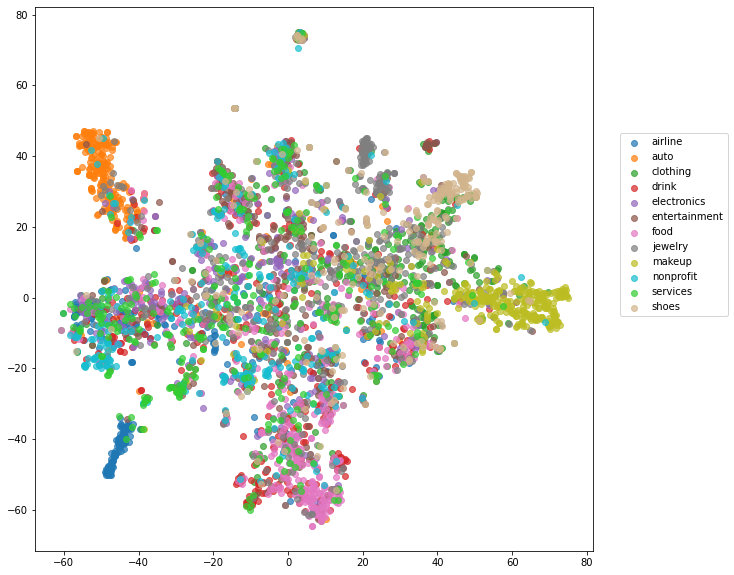

In [490]:
tsne_visualize_embeddings(all_node_emb, category_label, 'ss', save=False)

/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/adam/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(4108, 2)


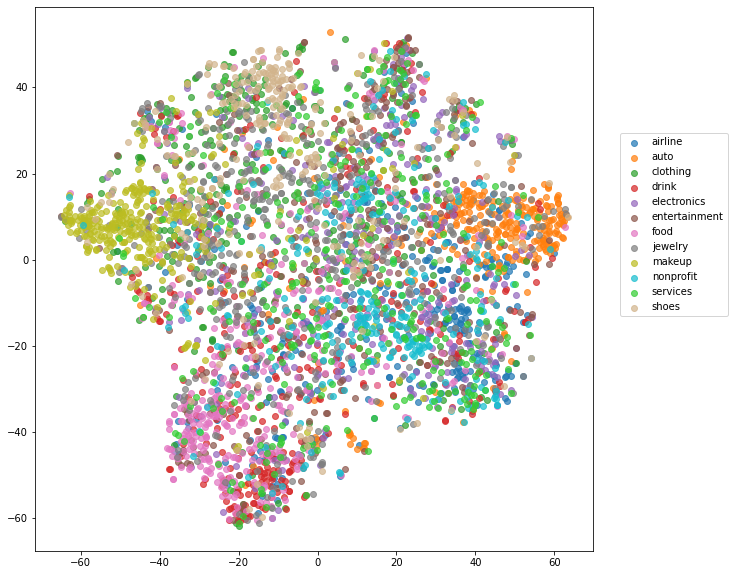

In [66]:
tsne_visualize_embeddings(all_node_emb, category_label, 'ss', save=False)

# 建立要視覺化的 concept dictionary

In [6]:
with open('train_concept_profile_id_dict_new.pkl', 'rb') as f:
    my_concept_dict = pickle.load(f)

In [363]:
remain_concept_cat = {
    'cake': 'food',
    'baking': 'food',
    'food': 'food',
    'chef': 'food',
    'restaurant': 'food',
    'recipe': 'food',
    'drink': 'drink',
    'brewer': 'drink',
    'beer': 'drink',
    'whiskey': 'drink',
    'cocktail': 'drink',
    'vodka': 'drink',
    'makeup': 'makeup',
    'lipstick': 'makeup',
    'cosmetics': 'makeup',
    'eyeliner': 'makeup',
    'beauty': 'makeup',
    'skincare': 'makeup',
    'clothes': 'clothing',
    'shirt': 'clothing',
    'outfit': 'clothing',
    'pants': 'clothing',
    'airline': 'airline',
    'pilot': 'airline',
    'aviation': 'airline',
    'airplane': 'airline',
    'auto': 'auto',
    'car': 'auto',
    'driver': 'auto',
    'truck': 'auto',
    'motorbike': 'auto',
    'automotive-manufacturing': 'auto'
}

In [364]:
with open('remain_concept_cat.pkl', 'wb') as f:
    pickle.dump(remain_concept_cat, f)